In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
ROOT_PATH = '/content/drive/My Drive/Group21_MLAH'

Mounted at /content/drive


## Load libraries and setup environment

In [ ]:
# Import libraries

!pip install tslearn
!pip install minisom
!pip install dtw-python
!pip install Levenshtein


from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from minisom import MiniSom
from dtw import dtw

from datetime import timedelta
import os

import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

import bigframes.pandas as bf
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

from gensim.models import Word2Vec

from IPython.display import clear_output

import torch

import copy
import datetime
import sys




In [ ]:
bf.options.bigquery.location = "US"
# bf.options.bigquery.project = 'mimic-iv-431207'


# authenticate
auth.authenticate_user()

# Set up environment variables
# project_id = 'mimic-iv-431207'
bf.options.bigquery.project = 'loyal-mason-431106-n3'
project_id = 'loyal-mason-431106-n3'

os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
dataset = 'mimiciv'

# bf.options.bigquery.location = "US"
# bf.options.bigquery.project = 'mimic-iv-431207'

# # authenticate
# auth.authenticate_user()

# # Set up environment variables
# project_id = 'mimic-iv-431207'
# os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
# dataset = 'mimiciv'


## **Load embedding mapping from itemid to vectors**

In [ ]:
# load embedding vectors
df_itemid_to_vector = pd.read_csv(ROOT_PATH + '/Code/itemid_to_vector.csv')
itemid_to_vector = {str(key): value for key, value in df_itemid_to_vector.set_index('itemid').T.to_dict('list').items()}
print(len(itemid_to_vector))


418


## **Find patients with AD related ICD codes.**

Load all diagnoses icd table, and filter with our event list:

## Possible Tests

## **See what tests are taken by these patients**

In [ ]:
# See what labtests are taken for these patients

query = """
        WITH ad_patients_diagnosed AS (
        SELECT
        d.subject_id,
        d.hadm_id,
        d.icd_code,
        CASE WHEN d.icd_code LIKE '331%' or d.icd_code LIKE 'G30%' THEN 1 ELSE 0 END AS label_ad
        FROM
            physionet-data.mimiciv_hosp.diagnoses_icd AS d
        WHERE
          (
            d.icd_code LIKE 'G30%' OR
            d.icd_code LIKE 'F01%' OR
            d.icd_code LIKE 'F03%' OR
            d.icd_code LIKE 'F02%' OR
            d.icd_code LIKE 'R54%' OR
            d.icd_code IN ('G318', 'G310', 'G311', 'G318', 'G319', '3310', '3311', '3312', '3319', '2904', '2900', '2901', '2902', '2903', '2908', '2909', '797')
          )
        ),
        lab_event_patients AS (
          SELECT
            d.subject_id,
            l.hadm_id,
            d.icd_code,
            l.itemid,
            l.valuenum,
            l.labevent_id,
            l.charttime,
            l.flag,
            d.label_ad
          FROM
            physionet-data.mimiciv_hosp.labevents AS l
          JOIN
            ad_patients_diagnosed d
          ON
            d.subject_id = l.subject_id
          WHERE l.valuenum IS NOT NULL
          AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
          AND l.hadm_id < d.hadm_id

        )
        SELECT l.*,
          dlab.label,
          dlab.fluid,
          dlab.category
        FROM lab_event_patients AS l
        JOIN
          physionet-data.mimiciv_hosp.d_labitems AS dlab
        ON
          l.itemid = dlab.itemid
        WHERE
          lower(dlab.fluid) LIKE '%blood%'
"""
df_ad_patients_lab_results = bf.read_gbq(query).sort_values(by=['subject_id', 'charttime', 'labevent_id']).reset_index(drop=True)
print(len(df_ad_patients_lab_results))
df_ad_patients_lab_results.head(10)


2926753


,subject_id,hadm_id,icd_code,itemid,valuenum,labevent_id,charttime,flag,label_ad,label,fluid,category
0,10000084,23052089,F0280,51133,2.86,672,2160-11-20 22:30:00,<NA>,0,Absolute Lymphocyte Count,Blood,Hematology
1,10000084,23052089,F0280,51146,0.6,673,2160-11-20 22:30:00,<NA>,0,Basophils,Blood,Hematology
2,10000084,23052089,F0280,51200,2.0,674,2160-11-20 22:30:00,<NA>,0,Eosinophils,Blood,Hematology
3,10000084,23052089,F0280,51221,38.2,675,2160-11-20 22:30:00,abnormal,0,Hematocrit,Blood,Hematology
4,10000084,23052089,F0280,51222,12.8,676,2160-11-20 22:30:00,abnormal,0,Hemoglobin,Blood,Hematology
5,10000084,23052089,F0280,51244,33.3,677,2160-11-20 22:30:00,<NA>,0,Lymphocytes,Blood,Hematology
6,10000084,23052089,F0280,51248,31.8,678,2160-11-20 22:30:00,<NA>,0,MCH,Blood,Hematology
7,10000084,23052089,F0280,51249,33.5,679,2160-11-20 22:30:00,<NA>,0,MCHC,Blood,Hematology
8,10000084,23052089,F0280,51250,95.0,680,2160-11-20 22:30:00,<NA>,0,MCV,Blood,Hematology
9,10000084,23052089,F0280,51254,15.9,681,2160-11-20 22:30:00,abnormal,0,Monocytes,Blood,Hematology


In [ ]:
query = """
  SELECT
      d.subject_id,
      l.hadm_id,
      d.icd9_code as icd_code,
      9 as icd_version,
      l.itemid,
      l.valuenum,
      l.valueuom,
      l.row_id AS labevent_id,
      l.charttime,
      l.flag,
      dlab.label,
      dlab.fluid,
      dlab.category,
      CASE WHEN d.icd9_code LIKE '331%' THEN 1 ELSE 0 END AS label_ad
    FROM
        `physionet-data.mimiciii_clinical.diagnoses_icd` AS d
    JOIN
        `physionet-data.mimiciii_clinical.labevents` AS l
    ON
        d.subject_id = l.subject_id
    JOIN
        `physionet-data.mimiciii_clinical.admissions` AS a
    ON
        l.subject_id = a.subject_id
    INNER JOIN
      `physionet-data.mimiciii_clinical.d_labitems` AS dlab
    ON
      l.itemid = dlab.itemid
    WHERE
      d.icd9_code LIKE '331%'  -- ICD-9 codes for Alzheimer's and related diseases
      AND l.valuenum IS NOT NULL
      # AND l.charttime <= a.dischtime
      AND l.hadm_id < a.hadm_id  -- Only include hadm_id before first AD diagnosis
      AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
      # AND (LOWER(l.flag) LIKE 'abnormal%')
      AND lower(dlab.fluid) LIKE '%blood%'
"""
df_itemid_sequences_3 = bf.read_gbq(query)
print(len(df_itemid_sequences_3))
df_itemid_sequences_3 = df_itemid_sequences_3.to_pandas()
df_itemid_sequences_3.head(10)

557779


,subject_id,hadm_id,icd_code,icd_version,itemid,valuenum,valueuom,labevent_id,charttime,flag,label,fluid,category,label_ad
0,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
1,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
2,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
3,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
4,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
5,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
6,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
7,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
8,93900,156863,3310,9,51279,3.63,m/uL,27096276,2101-09-06 13:00:00,abnormal,Red Blood Cells,Blood,Hematology,1
9,20181,129110,3319,9,50821,130.0,mm Hg,12490565,2176-03-25 02:59:00,abnormal,pO2,Blood,Blood Gas,1


For each patient, only keep the test data with charttime before their diagnoses' dischargetime

In [ ]:
# df_temp = df_ad_patients_with_discharge_time[['subject_id', 'hadm_id', 'discharge_time']].drop_duplicates(subset=['subject_id', 'hadm_id']).to_pandas()
# df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()

# df_ad_patients_lab_results_pd = pd.merge(df_ad_patients_lab_results_pd, df_temp, on=['subject_id', 'hadm_id'], how='left')

# df_ad_patients_lab_results_pd = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['charttime'] <= df_ad_patients_lab_results_pd['discharge_time']].reset_index(drop=True)

# print(len(df_ad_patients_lab_results_pd))
# df_ad_patients_lab_results_pd.head(10)


In [ ]:
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()
df_ad_patients_lab_results_pd['itemid'] = df_ad_patients_lab_results_pd['itemid'].astype(str)
df_ad_patients_lab_results_pd.dtypes

,0
subject_id,Int64
hadm_id,Int64
icd_code,string[pyarrow]
itemid,object
valuenum,Float64
labevent_id,Int64
charttime,timestamp[us][pyarrow]
flag,string[pyarrow]
label_ad,Int64
label,string[pyarrow]


In [ ]:
# see how many unique patients:
print(len(df_ad_patients_lab_results_pd['subject_id'].unique()))

2964


In [ ]:
possible_tests = bf.read_gbq("""
  SELECT *
  FROM `physionet-data.mimiciv_hosp.d_labitems`
""")
ad_tests = list(set(df_ad_patients_lab_results['itemid']))
ad_test_names = possible_tests[possible_tests['itemid'].isin(ad_tests)].to_pandas()
ad_test_names['itemid'] = ad_test_names['itemid'].astype(str)

ad_test_names.head(1)

,itemid,label,fluid,category
5,51203,Factor IX,Blood,Hematology


In [ ]:
itemid_counts_df = df_ad_patients_lab_results_pd.groupby('itemid')['subject_id'].nunique().reset_index()
itemid_counts_df.columns = ['itemid', 'n_patients']
itemid_counts_df['itemid'] = itemid_counts_df['itemid'].astype(str)

merged_df = pd.merge(itemid_counts_df, ad_test_names, on='itemid', how='inner')
merged_df_sorted = merged_df.sort_values(by='n_patients', ascending=False)
merged_df_sorted

,itemid,n_patients,label,fluid,category
125,51006,2940,Urea Nitrogen,Blood,Chemistry
101,50971,2940,Potassium,Blood,Chemistry
64,50912,2940,Creatinine,Blood,Chemistry
164,51221,2938,Hematocrit,Blood,Hematology
190,51265,2936,Platelet Count,Blood,Hematology
...,...,...,...,...,...
245,51765,1,EE3,Blood,Chemistry
221,51654,1,HIV 1 Viral Load,Blood,Chemistry
241,51754,1,VZV IgG Ab Value,Blood,Chemistry
220,51652,1,High-Sensitivity CRP,Blood,Chemistry


### Clustering

In [ ]:
n_unique_patients = len(df_ad_patients_lab_results_pd['subject_id'].unique())
chosen_lab_test = merged_df_sorted[merged_df_sorted.n_patients > (0.50 * n_unique_patients)]
chosen_lab_test

,itemid,n_patients,label,fluid,category
125,51006,2940,Urea Nitrogen,Blood,Chemistry
101,50971,2940,Potassium,Blood,Chemistry
64,50912,2940,Creatinine,Blood,Chemistry
164,51221,2938,Hematocrit,Blood,Hematology
190,51265,2936,Platelet Count,Blood,Hematology
109,50983,2934,Sodium,Blood,Chemistry
54,50902,2933,Chloride,Blood,Chemistry
34,50868,2930,Anion Gap,Blood,Chemistry
39,50882,2930,Bicarbonate,Blood,Chemistry
208,51301,2929,White Blood Cells,Blood,Hematology


In [ ]:
# df_ad_patients_lab_results_only = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd.label_ad == 1]
# no_icdcode_ad_patients_lab_results = df_ad_patients_lab_results_pd.drop(columns=['icd_code', 'icd_version']).copy()
no_icdcode_ad_patients_lab_results = df_ad_patients_lab_results_pd.drop(columns=['icd_code']).copy()
no_icdcode_ad_patients_lab_results['is_icd10_code'] = 1
no_icdcode_ad_patients_lab_results = no_icdcode_ad_patients_lab_results.drop_duplicates()
no_icdcode_ad_patients_lab_results = no_icdcode_ad_patients_lab_results.reset_index(drop=True)

# df_ad_patients_lab_results_only_3 = df_itemid_sequences_3[df_itemid_sequences_3.label_ad == 1]
# no_icdcode_mimic3_patients = df_itemid_sequences_3.drop(columns=['icd_code', 'icd_version']).copy()
no_icdcode_mimic3_patients = df_itemid_sequences_3.drop(columns=['icd_code']).copy()
no_icdcode_mimic3_patients['is_icd10_code'] = 0
no_icdcode_mimic3_patients = no_icdcode_mimic3_patients.drop_duplicates()
no_icdcode_mimic3_patients = no_icdcode_mimic3_patients.reset_index(drop=True)

all_ad_patients_lab_results = pd.concat([no_icdcode_ad_patients_lab_results, no_icdcode_mimic3_patients], ignore_index=True)
all_ad_patients_lab_results.head(10)

,subject_id,hadm_id,itemid,valuenum,labevent_id,charttime,flag,label_ad,label,fluid,category,is_icd10_code,icd_version,valueuom
0,10000084,23052089,51133,2.86,672,2160-11-20 22:30:00,<NA>,0,Absolute Lymphocyte Count,Blood,Hematology,1,<NA>,<NA>
1,10000084,23052089,51146,0.6,673,2160-11-20 22:30:00,<NA>,0,Basophils,Blood,Hematology,1,<NA>,<NA>
2,10000084,23052089,51200,2.0,674,2160-11-20 22:30:00,<NA>,0,Eosinophils,Blood,Hematology,1,<NA>,<NA>
3,10000084,23052089,51221,38.2,675,2160-11-20 22:30:00,abnormal,0,Hematocrit,Blood,Hematology,1,<NA>,<NA>
4,10000084,23052089,51222,12.8,676,2160-11-20 22:30:00,abnormal,0,Hemoglobin,Blood,Hematology,1,<NA>,<NA>
5,10000084,23052089,51244,33.3,677,2160-11-20 22:30:00,<NA>,0,Lymphocytes,Blood,Hematology,1,<NA>,<NA>
6,10000084,23052089,51248,31.8,678,2160-11-20 22:30:00,<NA>,0,MCH,Blood,Hematology,1,<NA>,<NA>
7,10000084,23052089,51249,33.5,679,2160-11-20 22:30:00,<NA>,0,MCHC,Blood,Hematology,1,<NA>,<NA>
8,10000084,23052089,51250,95.0,680,2160-11-20 22:30:00,<NA>,0,MCV,Blood,Hematology,1,<NA>,<NA>
9,10000084,23052089,51254,15.9,681,2160-11-20 22:30:00,abnormal,0,Monocytes,Blood,Hematology,1,<NA>,<NA>


In [ ]:
from tqdm import tqdm
latest_chosen_lab_test_results = {}
latest_chosen_lab_test_results['subject_id'] = []
latest_chosen_lab_test_results['is_icd10_code'] = []
latest_chosen_lab_test_results['label_ad'] = []
# latest_chosen_lab_test_results = {k: [] for k in chosen_lab_test.label.values}
for k in chosen_lab_test.label.values:
  latest_chosen_lab_test_results[k] = []
patient_ids = set(all_ad_patients_lab_results.subject_id)
for patientid in tqdm(patient_ids, total=len(patient_ids)):
  latest_chosen_lab_test_results['subject_id'].append(patientid)
  lab_test_results = all_ad_patients_lab_results[all_ad_patients_lab_results.subject_id == patientid]
  latest_chosen_lab_test_results['is_icd10_code'].append(lab_test_results.is_icd10_code.values[0])
  latest_chosen_lab_test_results['label_ad'].append(lab_test_results.label_ad.values[0])
  for test_label in chosen_lab_test.label.values:
    lab_test = lab_test_results[lab_test_results.label == test_label]
    lab_test = lab_test.sort_values(by='charttime', ascending=False)
    lab_test = lab_test.reset_index(drop=True)
    if len(lab_test) > 0:
      lab_test_value = lab_test.iloc[0].valuenum
    else:
      lab_test_value = -1
    latest_chosen_lab_test_results[test_label].append(lab_test_value)

100%|██████████| 3271/3271 [09:07<00:00,  5.97it/s]


In [ ]:
patient_lab_test_df = pd.DataFrame.from_dict(latest_chosen_lab_test_results)
patient_lab_test_df

,subject_id,is_icd10_code,label_ad,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,...,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD,Albumin,I,H,L,Lactate
0,12722180,1,0,21.0,4.0,1.6,45.2,175.0,143.0,107.0,...,13.0,13.0,0.7,72.0,43.2,3.6,1.0,9.0,7.0,-1.0
1,24581,0,1,16.0,3.7,0.7,41.4,176.0,138.0,104.0,...,16.0,12.0,0.7,82.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,17367047,1,1,31.0,4.2,2.0,38.1,186.0,130.0,100.0,...,29.0,30.0,0.8,87.0,-1.0,2.9,-1.0,-1.0,-1.0,-1.0
3,15204362,1,0,49.0,4.4,2.2,36.2,213.0,137.0,92.0,...,23.0,15.0,0.7,86.0,47.8,-1.0,1.0,26.0,5.0,-1.0
4,16826378,1,0,27.0,4.8,1.0,33.7,257.0,137.0,103.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266,18718699,1,0,19.0,4.4,1.2,40.1,337.0,139.0,105.0,...,26.0,19.0,0.5,55.0,47.1,-1.0,-1.0,-1.0,-1.0,1.3
3267,18948084,1,0,43.0,3.1,1.8,23.6,28.0,140.0,105.0,...,19.0,12.0,0.5,84.0,-1.0,3.5,-1.0,-1.0,-1.0,-1.0
3268,18497527,1,0,7.0,4.4,0.8,37.9,256.0,134.0,96.0,...,36.0,16.0,1.3,59.0,-1.0,4.6,-1.0,-1.0,-1.0,-1.0
3269,16867320,1,0,20.0,4.1,1.1,40.3,147.0,139.0,101.0,...,29.0,15.0,0.2,66.0,43.3,3.8,1.0,4.0,4.0,1.0


In [ ]:
lab_test_results_only = patient_lab_test_df[patient_lab_test_df.columns[1:]]
lab_test_results_only.head(10)

,is_icd10_code,label_ad,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,...,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD,Albumin,I,H,L,Lactate
0,1,0,21.0,4.0,1.6,45.2,175.0,143.0,107.0,14.0,...,13.0,13.0,0.7,72.0,43.2,3.6,1.0,9.0,7.0,-1.0
1,0,1,16.0,3.7,0.7,41.4,176.0,138.0,104.0,13.0,...,16.0,12.0,0.7,82.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,1,31.0,4.2,2.0,38.1,186.0,130.0,100.0,11.0,...,29.0,30.0,0.8,87.0,-1.0,2.9,-1.0,-1.0,-1.0,-1.0
3,1,0,49.0,4.4,2.2,36.2,213.0,137.0,92.0,18.0,...,23.0,15.0,0.7,86.0,47.8,-1.0,1.0,26.0,5.0,-1.0
4,1,0,27.0,4.8,1.0,33.7,257.0,137.0,103.0,15.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,1,1,9.0,3.7,1.0,37.4,173.0,140.0,106.0,12.0,...,21.0,18.0,0.7,83.0,43.5,-1.0,1.0,2.0,3.0,-1.0
6,1,0,50.0,4.5,1.1,29.4,394.0,139.0,99.0,13.0,...,-1.0,-1.0,-1.0,-1.0,56.5,-1.0,0.0,6.0,20.0,2.6
7,1,1,18.0,4.1,1.2,31.4,106.0,140.0,104.0,14.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,1,0,12.0,4.8,0.5,31.8,353.0,137.0,100.0,18.0,...,-1.0,-1.0,-1.0,-1.0,48.4,-1.0,1.0,5.0,3.0,1.2
9,0,1,35.0,4.2,0.8,30.7,302.0,144.0,108.0,13.0,...,80.0,139.0,0.3,116.0,-1.0,3.2,-1.0,-1.0,-1.0,1.4


In [ ]:
lab_test_results_only.columns

Index(['is_icd10_code', 'label_ad', 'Urea Nitrogen', 'Potassium', 'Creatinine',
       'Hematocrit', 'Platelet Count', 'Sodium', 'Chloride', 'Anion Gap',
       'Bicarbonate', 'White Blood Cells', 'Hemoglobin', 'MCV', 'Glucose',
       'MCHC', 'Red Blood Cells', 'RDW', 'MCH', 'Magnesium', 'Calcium, Total',
       'Phosphate', 'INR(PT)', 'PT', 'PTT', 'Monocytes', 'Neutrophils',
       'Eosinophils', 'Lymphocytes', 'Basophils',
       'Asparate Aminotransferase (AST)', 'Alanine Aminotransferase (ALT)',
       'Bilirubin, Total', 'Alkaline Phosphatase', 'RDW-SD', 'Albumin', 'I',
       'H', 'L', 'Lactate'],
      dtype='object')

### Remove outlier

In [ ]:
## Find outliers and extreme outliers

def find_outlier(data, col, std=1.5):

    ### Calculate the IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    ### Find lower and upper bound of non-outlier values
    lower = round(Q1 - std * IQR, 2)
    upper = round(Q3 + std * IQR, 2)

    ### Find ouliers based on the lowest and upper bound outlier values
    lower_values = np.array(data[col] <= lower)
    upper_values = np.array(data[col] >= upper)
    print(f'Outlier for {col}:')
    print(f"Lower Bound: {lower}. Total rows: {lower_values.sum()}")
    print(f"Upper Bound: {upper}. Total rows: {upper_values.sum()}\n")
    return lower, upper

In [ ]:
outlier_bound = {}
numericals = lab_test_results_only.columns[2:]
for col in numericals:
    outlier_bound[col] = find_outlier(lab_test_results_only, col)

Outlier for Urea Nitrogen:
Lower Bound: -8.0. Total rows: 0
Upper Bound: 48.0. Total rows: 227

Outlier for Potassium:
Lower Bound: 2.9. Total rows: 28
Upper Bound: 5.3. Total rows: 68

Outlier for Creatinine:
Lower Bound: -0.05. Total rows: 26
Upper Bound: 1.95. Total rows: 297

Outlier for Hematocrit:
Lower Bound: 17.05. Total rows: 30
Upper Bound: 48.65. Total rows: 4

Outlier for Platelet Count:
Lower Bound: -4.0. Total rows: 0
Upper Bound: 460.0. Total rows: 132

Outlier for Sodium:
Lower Bound: 129.5. Total rows: 60
Upper Bound: 149.5. Total rows: 29

Outlier for Chloride:
Lower Bound: 91.0. Total rows: 72
Upper Bound: 115.0. Total rows: 40

Outlier for Anion Gap:
Lower Bound: 7.5. Total rows: 64
Upper Bound: 19.5. Total rows: 124

Outlier for Bicarbonate:
Lower Bound: 15.5. Total rows: 73
Upper Bound: 35.5. Total rows: 51

Outlier for White Blood Cells:
Lower Bound: 0.03. Total rows: 35
Upper Bound: 15.42. Total rows: 136

Outlier for Hemoglobin:
Lower Bound: 4.85. Total rows: 3

In [ ]:
no_outlier = lab_test_results_only.copy()

### Exclude any outliers
# for col, bound_value in outlier_bound.items():
#     no_outlier = no_outlier[(no_outlier[col] > bound_value[0]) & (no_outlier[col] < bound_value[1])]

data_kmeans = no_outlier.copy()

## Standardize numerical variables
scaler = StandardScaler()
no_outlier[numericals] = scaler.fit_transform(no_outlier[numericals])

data_to_fit = no_outlier.copy()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_to_fit)
data_pca = pd.DataFrame(data_pca, columns=['pca1', 'pca2'])
data_pca.head()

,pca1,pca2
0,2.056390,0.842237
1,0.615271,1.619118
2,1.066978,-0.467595
3,-2.519182,2.110912
4,0.142855,0.506972


In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score

### List to store each metric value
distortions = []
inertias = []
silhouette = []
ch = []

### Analyse k-elbow from 2 to 12 clusters
K = range(2, 12)

for k in K:
    ### Building and fitting the model
    ### Increase the iteration to 500 and reduce the tol to 1e-7 so the model is converged
    kmean_model = KMeans(n_clusters=k, max_iter=500, tol=1e-7)
    y_kmeans = kmean_model.fit_predict(data_to_fit)
    data_pca[f'k{k}'] = y_kmeans
    data_kmeans[f'k{k}'] = y_kmeans

    ### Metrics for calculations
    ### I use several metrics such as distortions, inertias, and silhoutte
    distortions.append(sum(np.min(cdist(data_to_fit, kmean_model.cluster_centers_,'euclidean'), axis=1)) / data_to_fit.shape[0])
    inertias.append(kmean_model.inertia_)
    silhouette.append(silhouette_score(data_to_fit, kmean_model.labels_, metric='euclidean'))
    ch.append(calinski_harabasz_score(data_to_fit, kmean_model.labels_))

In [ ]:
### Print each cluster metric value for each k-value

for k, (d, i, s, c) in enumerate(zip(distortions, inertias, silhouette, ch)):
    print(f'k={k+2}. Distortion: {round(d, 3)}; Inertia: {round(i, 3)}; Silhouette: {round(s, 3)}; Calinski Harabasz: {round(c, 3)}')

k=2. Distortion: 4.94; Inertia: 112104.743; Silhouette: 0.158; Calinski Harabasz: 385.864
k=3. Distortion: 4.813; Inertia: 106991.071; Silhouette: 0.128; Calinski Harabasz: 280.189
k=4. Distortion: 4.636; Inertia: 91203.464; Silhouette: 0.122; Calinski Harabasz: 407.569
k=5. Distortion: 4.476; Inertia: 86342.357; Silhouette: 0.112; Calinski Harabasz: 368.757
k=6. Distortion: 4.476; Inertia: 81766.981; Silhouette: 0.093; Calinski Harabasz: 347.957
k=7. Distortion: 4.287; Inertia: 79575.554; Silhouette: 0.105; Calinski Harabasz: 312.84
k=8. Distortion: 4.32; Inertia: 76065.55; Silhouette: 0.1; Calinski Harabasz: 301.946
k=9. Distortion: 4.27; Inertia: 78734.377; Silhouette: 0.087; Calinski Harabasz: 241.347
k=10. Distortion: 4.131; Inertia: 70201.593; Silhouette: 0.099; Calinski Harabasz: 284.573
k=11. Distortion: 4.181; Inertia: 70270.692; Silhouette: 0.104; Calinski Harabasz: 255.465


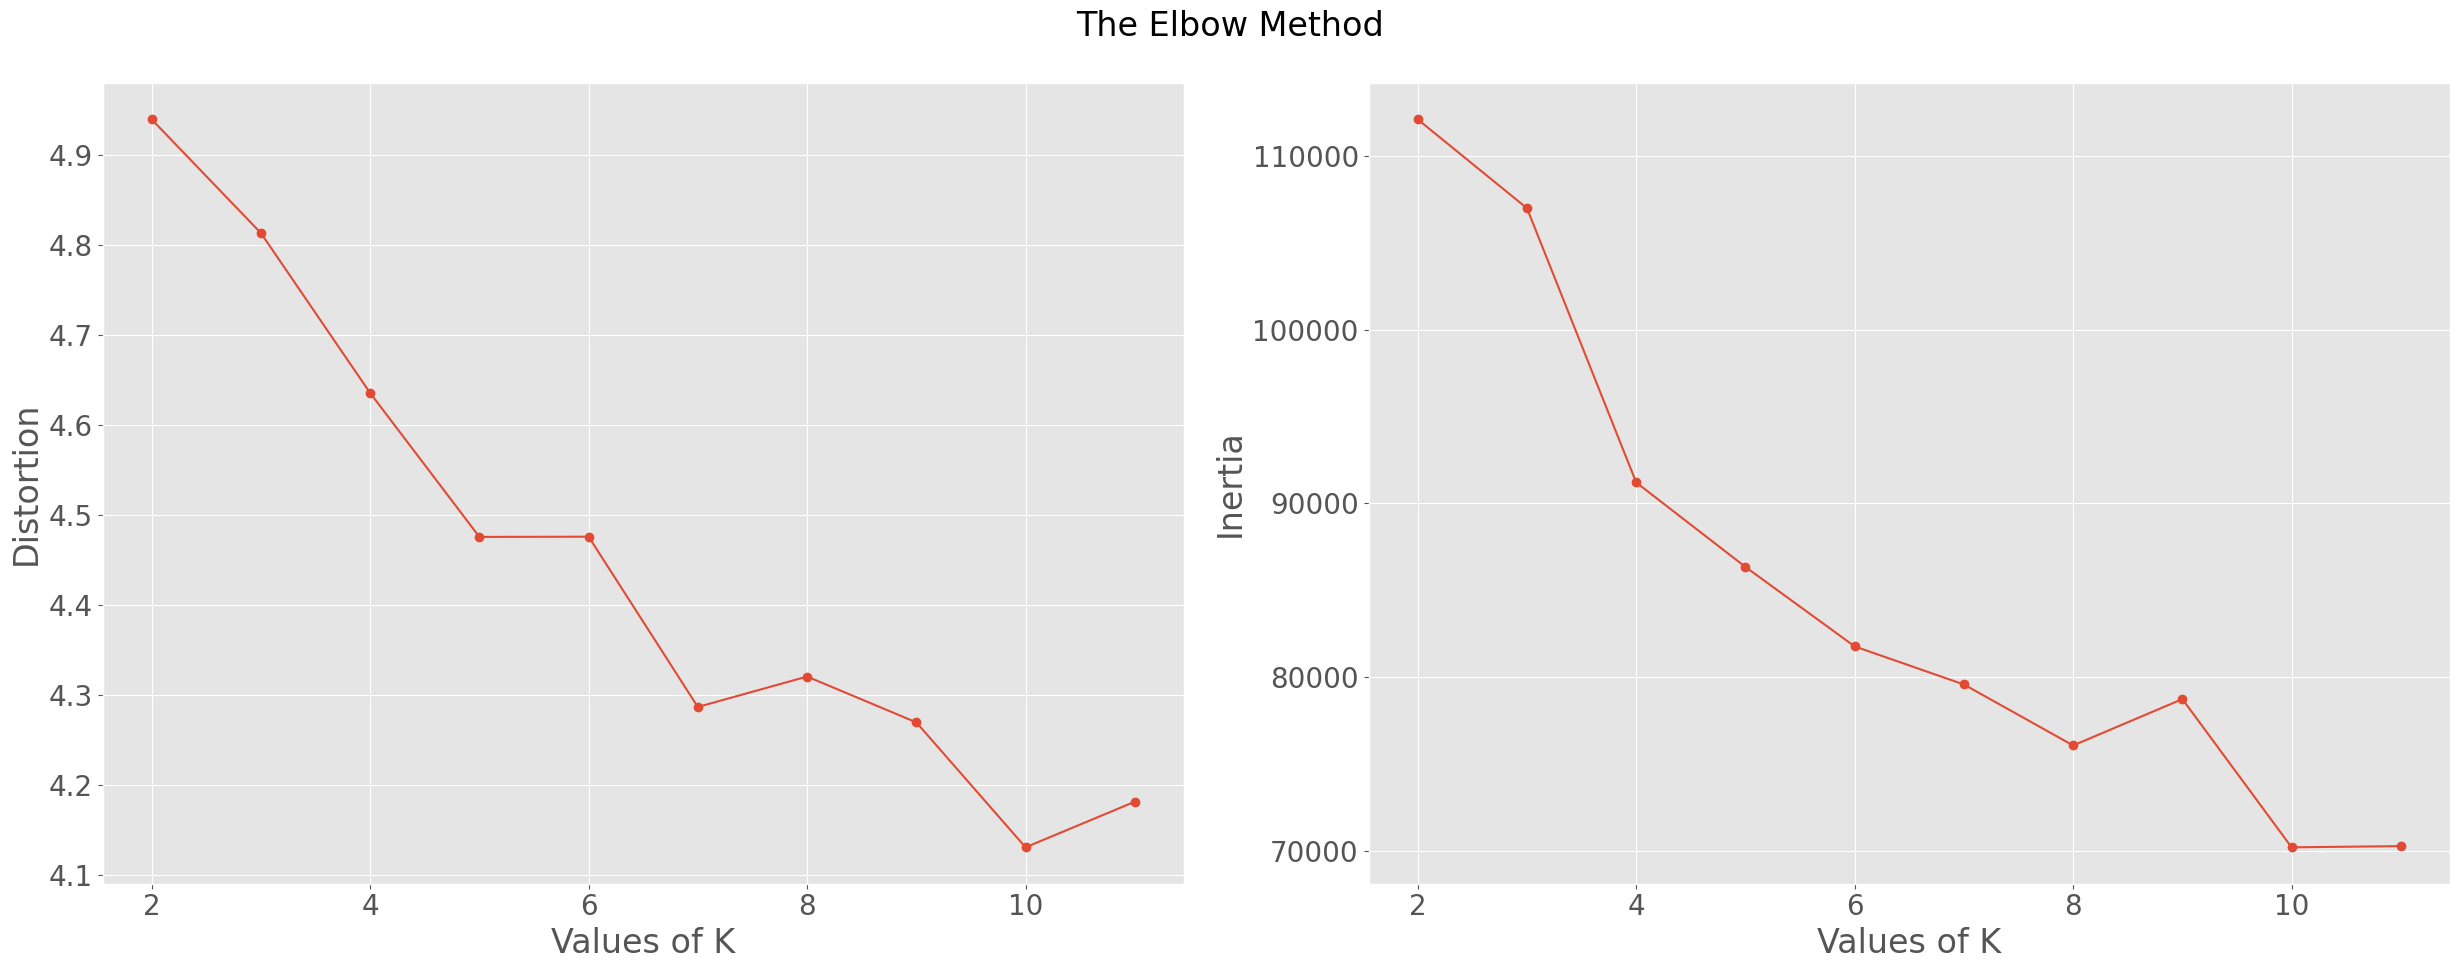

In [ ]:
### K-elbow method visualisation to choose the optimal number of k cluster
### Our goal is to chose k at the elbow point

fig, axs = plt.subplots(1, 2, figsize=(25,10))

axs[0].plot(K, distortions, marker="o")
axs[0].set_xlabel('Values of K')
axs[0].set_ylabel('Distortion')
axs[1].plot(K, inertias, marker="o")
axs[1].set_xlabel('Values of K')
axs[1].set_ylabel('Inertia')
fig.suptitle('The Elbow Method')
plt.tight_layout()
plt.show()

<ipython-input-50-8d50af24bf73>:5: UserWarning:

The palette list has more values (7) than needed (2), which may not be intended.

<ipython-input-50-8d50af24bf73>:5: UserWarning:

The palette list has more values (7) than needed (3), which may not be intended.

<ipython-input-50-8d50af24bf73>:5: UserWarning:

The palette list has more values (7) than needed (4), which may not be intended.

<ipython-input-50-8d50af24bf73>:5: UserWarning:

The palette list has more values (7) than needed (5), which may not be intended.

<ipython-input-50-8d50af24bf73>:5: UserWarning:

The palette list has more values (7) than needed (6), which may not be intended.

<ipython-input-50-8d50af24bf73>:5: UserWarning:


The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.

<ipython-input-50-8d50af24bf73>:5: UserWarning:


The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.

<ipython-input-50

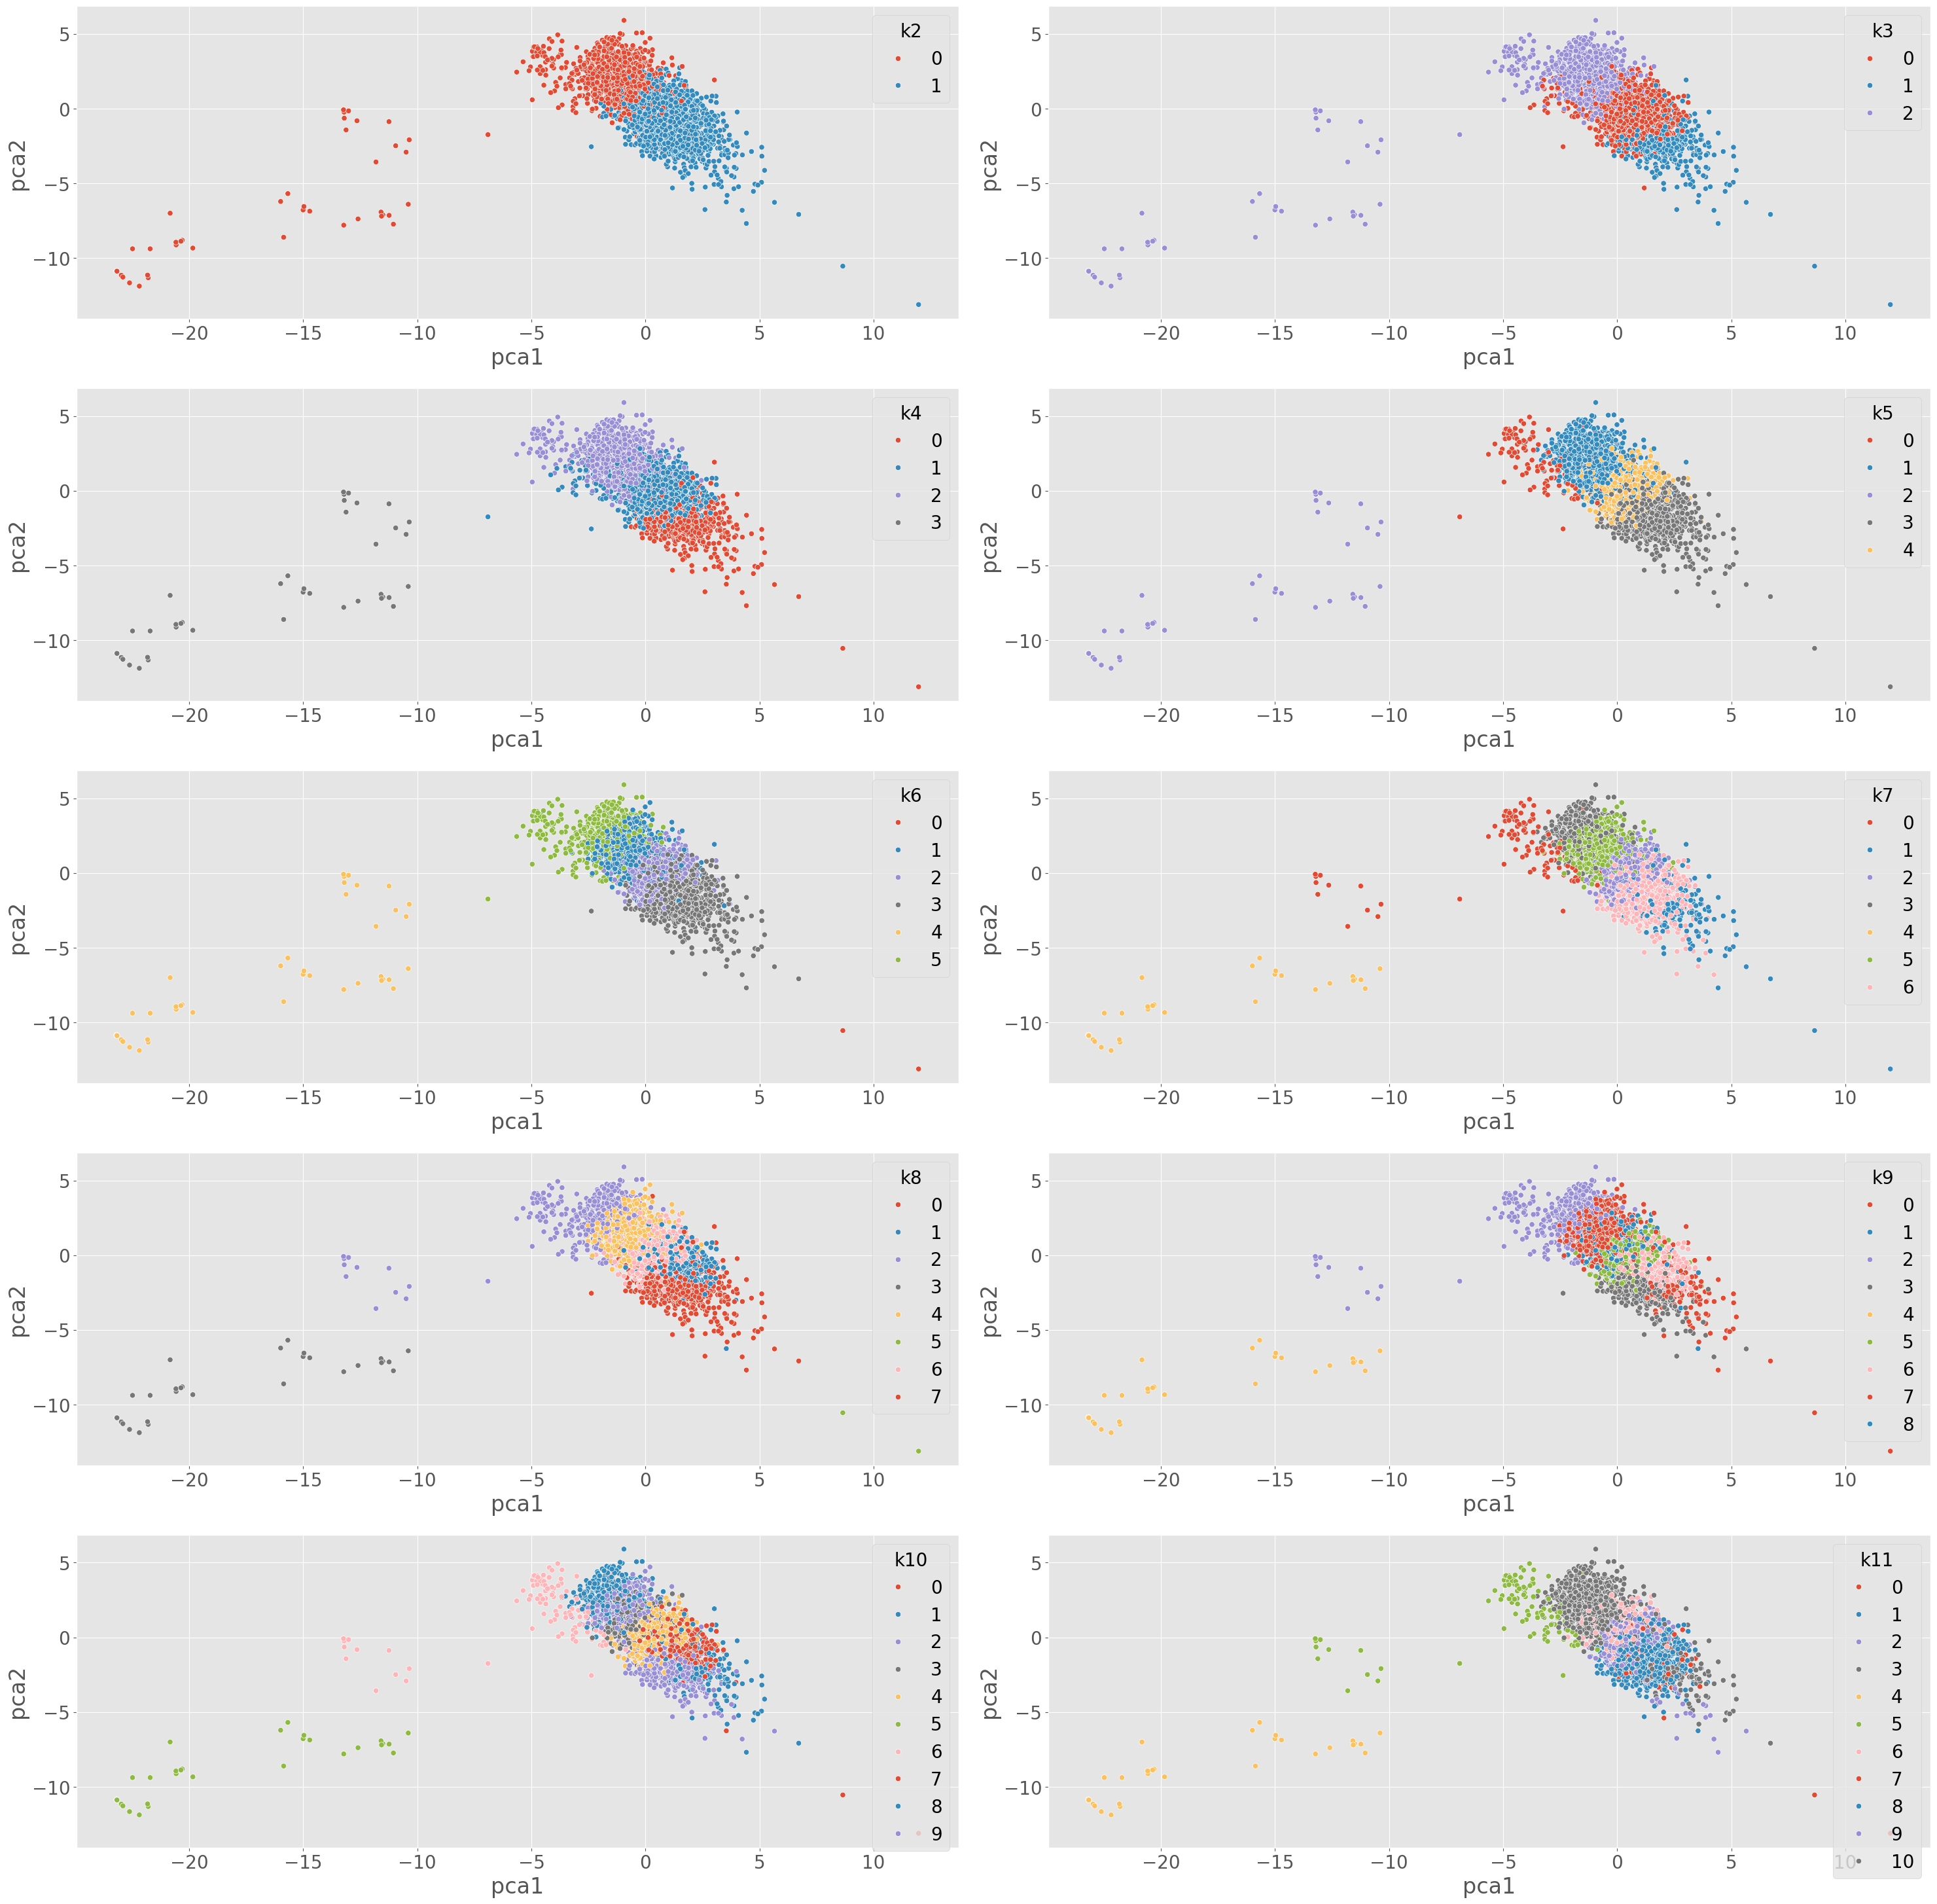

In [ ]:
### Plot of cluster distribution with PCA to 2d dimension
fig, axs = plt.subplots(5, 2, figsize=(30,30))

for i, ax in enumerate(axs.flatten()):
  sns.scatterplot(data=data_pca, x="pca1", y="pca2", hue=f"k{i+2}", ax=ax, palette=sns.color_palette())
plt.tight_layout()
plt.show()

### Cluster Result

In [ ]:
# ### Information related to each cluster

# data_visualise = data_kmeans[lab_test_results_only.columns].copy()
# data_visualise['k6'] = data_kmeans.k6

# i = 0
# j = 10
# ### Statistical information of numerical features related to cluster 0
# display(data_visualise[numericals[i:j]][data_visualise.k6 == 0].describe())

# ### Statistical information of numerical features related to cluster 1
# display(data_visualise[numericals[i:j]][data_visualise.k6 == 1].describe())

# ### Statistical information of numerical features related to cluster 2
# display(data_visualise[numericals[i:j]][data_visualise.k6 == 2].describe())

# ### Statistical information of numerical features related to cluster 3
# display(data_visualise[numericals[i:j]][data_visualise.k6 == 3].describe())

# ### Statistical information of numerical features related to cluster 4
# display(data_visualise[numericals[i:j]][data_visualise.k6 == 4].describe())

# ### Statistical information of numerical features related to cluster 5
# display(data_visualise[numericals[i:j]][data_visualise.k6 == 5].describe())

# ### Statistical information of numerical features related to cluster 6
# # display(data_visualise[numericals[i:j]][data_visualise.k7 == 6].describe())

### Information related to each cluster
data_visualise = data_kmeans[lab_test_results_only.columns].copy()
data_visualise['k7'] = data_kmeans.k7
i = 0
j = 33
### Statistical information of numerical features related to cluster 0
display(data_visualise[numericals[i:j]][data_visualise.k7 == 0].describe())
### Statistical information of numerical features related to cluster 1
display(data_visualise[numericals[i:j]][data_visualise.k7 == 1].describe())
### Statistical information of numerical features related to cluster 2
display(data_visualise[numericals[i:j]][data_visualise.k7 == 2].describe())
### Statistical information of numerical features related to cluster 3
display(data_visualise[numericals[i:j]][data_visualise.k7 == 3].describe())
### Statistical information of numerical features related to cluster 4
display(data_visualise[numericals[i:j]][data_visualise.k7 == 4].describe())
### Statistical information of numerical features related to cluster 5
display(data_visualise[numericals[i:j]][data_visualise.k7 == 5].describe())
## Statistical information of numerical features related to cluster 6
display(data_visualise[numericals[i:j]][data_visualise.k7 == 6].describe())

,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,18.208000,3.716800,0.827200,35.987200,240.440000,127.400000,93.312000,12.432000,23.424000,7.867200,...,2.394400,27.112800,0.268800,9.149600,-0.408800,5.936000,3.928000,-0.654400,18.648000,16.211200
std,12.450739,1.484041,0.583147,4.869838,118.239396,40.143694,31.039625,5.003766,8.456019,2.653475,...,4.461435,34.334916,1.872269,13.716547,0.723568,18.267168,11.288858,0.649007,48.354747,23.164479
min,-1.000000,-1.000000,-1.000000,22.500000,54.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.900000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,12.000000,3.700000,0.700000,32.700000,177.000000,137.000000,100.000000,11.000000,23.000000,5.800000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,17.000000,4.000000,0.900000,36.000000,226.000000,139.000000,103.000000,13.000000,26.000000,7.500000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,22.000000,4.300000,1.100000,39.200000,273.000000,141.000000,105.000000,15.000000,28.000000,9.900000,...,6.100000,64.800000,1.200000,19.700000,0.300000,-1.000000,-1.000000,-1.000000,-1.000000,44.500000
max,94.000000,7.100000,2.200000,48.500000,1116.000000,149.000000,113.000000,22.000000,33.000000,14.900000,...,15.500000,91.000000,7.000000,59.000000,1.200000,165.000000,66.000000,1.400000,426.000000,57.800000


,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,59.259414,4.533473,3.361506,28.548117,233.748954,140.108787,102.104603,17.803347,22.531381,13.458577,...,5.729707,63.150209,1.323849,11.158159,0.100837,168.732218,83.786611,0.597071,117.518828,42.036820
std,26.226864,0.761445,1.913405,5.147299,121.556968,6.052006,8.162320,4.925392,6.530959,15.416242,...,4.702163,31.098903,2.537628,12.222905,0.550400,1255.867986,482.362133,1.413512,113.950226,27.648866
min,15.000000,3.000000,0.500000,10.300000,17.000000,119.000000,80.000000,9.000000,3.000000,0.100000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,41.000000,4.000000,1.900000,25.100000,156.000000,136.000000,97.000000,15.000000,19.000000,6.600000,...,2.600000,60.000000,0.000000,4.000000,0.000000,16.000000,9.000000,0.200000,70.000000,-1.000000
50%,54.000000,4.500000,2.800000,27.500000,221.000000,140.000000,102.000000,17.000000,22.000000,9.700000,...,5.700000,75.500000,0.500000,9.000000,0.200000,23.000000,17.000000,0.400000,93.000000,51.600000
75%,73.500000,5.000000,4.300000,31.650000,293.000000,143.000000,107.000000,20.000000,26.000000,13.350000,...,8.850000,83.050000,2.000000,14.900000,0.400000,41.000000,33.500000,0.600000,130.000000,59.600000
max,150.000000,8.400000,10.100000,47.800000,709.000000,173.000000,142.000000,37.000000,47.000000,166.500000,...,27.600000,96.500000,16.400000,100.000000,1.300000,16600.000000,5200.000000,13.700000,960.000000,113.900000


,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,...,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000
mean,19.720961,4.020828,0.967557,32.816822,266.642190,139.385848,103.918558,12.719626,26.802403,8.407744,...,5.326035,74.479172,2.178638,16.977704,0.393324,22.477971,20.853138,0.057944,63.228304,2.477170
std,10.022347,0.457900,0.459018,4.842090,125.579087,3.729756,4.520309,2.496286,3.793598,3.500618,...,2.608512,12.646312,3.547217,10.571292,0.350223,26.741406,31.778433,0.817723,65.652484,12.517715
min,3.000000,3.000000,0.200000,19.600000,18.000000,123.000000,88.000000,6.000000,15.000000,0.800000,...,0.000000,13.700000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,13.000000,3.700000,0.700000,29.200000,183.000000,137.000000,101.000000,11.000000,25.000000,6.000000,...,3.700000,66.600000,0.500000,9.000000,0.200000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,18.000000,4.000000,0.900000,32.700000,247.000000,140.000000,104.000000,13.000000,26.000000,7.700000,...,5.000000,76.300000,1.400000,15.000000,0.300000,19.000000,13.000000,0.300000,63.000000,-1.000000
75%,25.000000,4.300000,1.100000,36.200000,319.000000,142.000000,107.000000,14.000000,29.000000,10.100000,...,6.700000,84.000000,2.700000,23.100000,0.500000,31.000000,25.000000,0.500000,90.000000,-1.000000
max,71.000000,6.200000,4.700000,48.500000,1387.000000,152.000000,119.000000,21.000000,41.000000,31.000000,...,24.000000,97.100000,62.500000,77.800000,2.700000,265.000000,284.000000,6.600000,605.000000,55.700000


,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,...,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,20.361179,4.073956,1.028747,34.705897,232.265356,139.651106,103.606880,13.422604,25.845209,8.006880,...,1.253563,19.264373,-0.199017,4.884521,-0.599754,6.547912,5.090909,-0.684029,16.751843,20.234889
std,11.778948,0.447279,0.673813,5.069251,86.959213,3.668686,4.492221,2.761145,3.543275,4.684909,...,3.874469,33.086898,1.596177,11.443228,0.656101,37.476653,29.674658,0.649604,45.781176,24.339348
min,4.000000,2.500000,0.200000,19.500000,54.000000,129.000000,91.000000,-1.000000,14.000000,1.700000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,13.000000,3.800000,0.700000,31.300000,176.500000,137.000000,101.000000,12.000000,24.000000,5.900000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,18.000000,4.000000,0.900000,34.900000,214.000000,140.000000,103.000000,13.000000,26.000000,7.400000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,24.000000,4.300000,1.150000,38.100000,271.000000,142.000000,107.000000,15.000000,28.000000,9.250000,...,4.000000,56.100000,0.200000,7.750000,0.100000,-1.000000,-1.000000,-1.000000,-1.000000,45.950000
max,112.000000,6.100000,7.900000,50.300000,594.000000,151.000000,129.000000,22.000000,47.000000,82.600000,...,17.100000,93.600000,11.900000,75.000000,1.500000,684.000000,544.000000,2.000000,477.000000,69.200000


,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.0,36.0,36.0,36.0,36.0,36.000000,36.000000,36.000000,36.000000,36.0
mean,9.750000,1.633333,0.058333,9.986111,45.472222,53.805556,39.750000,3.722222,6.916667,-0.813889,...,-1.0,-1.0,-1.0,-1.0,-1.0,2.527778,1.083333,-0.783333,16.333333,-1.0
std,11.697069,2.541316,1.036305,18.391320,92.184128,69.691081,51.843928,7.546470,12.294889,1.116667,...,0.0,0.0,0.0,0.0,0.0,9.228794,5.489601,0.559336,60.089457,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
50%,11.000000,3.400000,0.650000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
75%,18.000000,4.100000,1.000000,30.125000,-1.000000,139.000000,102.000000,10.000000,21.250000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
max,44.000000,5.000000,1.500000,56.400000,277.000000,144.000000,109.000000,24.000000,33.000000,5.700000,...,-1.0,-1.0,-1.0,-1.0,-1.0,37.000000,19.000000,0.900000,340.000000,-1.0


,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,...,656.0,656.0,656.0,656.0,656.0,656.000000,656.000000,656.00000,656.000000,656.000000
mean,20.344512,4.087805,1.035213,33.638110,237.753049,139.792683,103.443598,13.448171,25.926829,7.941921,...,-1.0,-1.0,-1.0,-1.0,-1.0,12.414634,13.658537,-0.28689,43.193598,24.027134
std,10.473678,0.417595,0.596013,5.175717,101.432819,3.482958,4.456732,2.688465,3.564132,3.025035,...,0.0,0.0,0.0,0.0,0.0,25.510699,46.085839,0.90406,64.786725,25.779336
min,3.000000,3.000000,0.300000,21.000000,53.000000,125.000000,85.000000,6.000000,14.000000,2.300000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
25%,13.000000,3.800000,0.700000,29.700000,170.000000,138.000000,101.000000,12.000000,23.000000,5.800000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
50%,18.000000,4.100000,0.900000,33.200000,216.000000,140.000000,104.000000,13.000000,26.000000,7.400000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000
75%,25.000000,4.300000,1.100000,37.400000,279.500000,142.000000,106.000000,15.000000,28.000000,9.425000,...,-1.0,-1.0,-1.0,-1.0,-1.0,21.000000,16.250000,0.50000,76.000000,48.800000
max,65.000000,5.700000,5.700000,52.300000,846.000000,153.000000,123.000000,27.000000,39.000000,23.300000,...,-1.0,-1.0,-1.0,-1.0,-1.0,444.000000,720.000000,6.00000,512.000000,80.500000


,Urea Nitrogen,Potassium,Creatinine,Hematocrit,Platelet Count,Sodium,Chloride,Anion Gap,Bicarbonate,White Blood Cells,...,Monocytes,Neutrophils,Eosinophils,Lymphocytes,Basophils,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),"Bilirubin, Total",Alkaline Phosphatase,RDW-SD
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,20.508971,4.161756,1.010104,32.798489,228.954674,140.554297,102.945231,13.501416,25.429651,7.869783,...,8.386591,69.765817,2.089330,18.157413,0.412861,26.359773,21.711048,0.485080,97.702550,50.938055
std,10.438435,0.505547,0.480963,5.453956,95.971679,3.938039,4.559087,2.851184,3.522210,3.550044,...,4.165130,13.559524,2.727395,10.721249,0.308698,29.855511,31.223319,1.167593,112.250106,8.222287
min,3.000000,3.000000,0.200000,18.300000,15.000000,127.000000,86.000000,4.000000,13.000000,0.800000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,13.000000,3.800000,0.700000,28.400000,169.000000,138.000000,100.000000,12.000000,23.000000,5.800000,...,6.000000,62.000000,0.400000,10.100000,0.200000,15.000000,9.000000,0.200000,60.000000,46.000000
50%,18.000000,4.100000,0.900000,32.700000,218.000000,141.000000,103.000000,13.000000,25.000000,7.400000,...,8.100000,70.800000,1.400000,16.700000,0.400000,21.000000,15.000000,0.400000,80.000000,49.700000
75%,26.000000,4.500000,1.200000,36.700000,276.000000,143.000000,106.000000,15.000000,27.000000,9.200000,...,10.200000,79.500000,2.800000,23.800000,0.600000,31.000000,24.000000,0.700000,108.500000,54.400000
max,62.000000,9.600000,4.800000,54.400000,919.000000,156.000000,124.000000,25.000000,43.000000,42.900000,...,77.000000,95.000000,44.700000,90.000000,2.100000,533.000000,426.000000,22.100000,2271.000000,86.500000


In [ ]:
data_visualise.to_csv(ROOT_PATH + '/data_visualise.csv', index=False)

### Baseline Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X = lab_test_results_only[lab_test_results_only.columns[2:]]
Y = lab_test_results_only.label_ad
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
# -------------------- SVM baseline --------------------

# SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred_lr = logistic.predict(X_test)

# -------------------- Decision Tree baseline --------------------

# Decision Tree
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Random Forest (Lasso-selected features)
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred, model_name):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'{model_name} Model:')
  print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n')

In [ ]:

# -------------------- Evaluation --------------------

# Evaluate models
evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")


SVM Model:
Accuracy: 0.7896, Precision: 0.7008, Recall: 0.7417, F1 Score: 0.7206

Logistic Regression Model:
Accuracy: 0.8049, Precision: 0.7222, Recall: 0.7583, F1 Score: 0.7398

Decision Tree Model:
Accuracy: 0.6921, Precision: 0.5856, Recall: 0.5417, F1 Score: 0.5628

Random Forest Model:
Accuracy: 0.7805, Precision: 0.7264, Recall: 0.6417, F1 Score: 0.6814



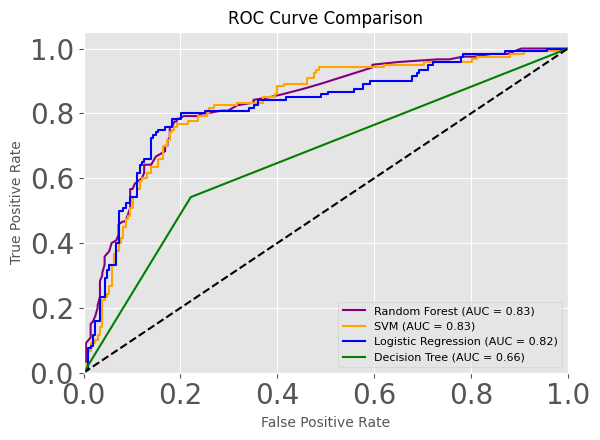

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(ax, fpr, tpr, auc, model_name, color):
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})', color=color)

fig, ax = plt.subplots()
# plot_roc_curve(ax, fpr_loaded, tpr_loaded, roc_auc_loaded, "Pre-Saved ROC", 'black')

roc_data = []

# Logistic Regression
lr_proba = logistic.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, lr_proba[:, 1])
auc = roc_auc_score(y_test, lr_proba[:, 1])
roc_data.append({'fpr': fpr, 'tpr': tpr, 'auc': auc, 'model_name': "Logistic Regression", 'color': 'blue'})

# Decision Tree
tree_proba = tree.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, tree_proba[:, 1])
auc = roc_auc_score(y_test, tree_proba[:, 1])
roc_data.append({'fpr': fpr, 'tpr': tpr, 'auc': auc, 'model_name': "Decision Tree", 'color': 'green'})

# SVM
svm_proba = svm.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, svm_proba[:, 1])
auc = roc_auc_score(y_test, svm_proba[:, 1])
roc_data.append({'fpr': fpr, 'tpr': tpr, 'auc': auc, 'model_name': "SVM", 'color': 'orange'})

# Random Forest
rf_proba = rf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, rf_proba[:, 1])
auc = roc_auc_score(y_test, rf_proba[:, 1])
roc_data.append({'fpr': fpr, 'tpr': tpr, 'auc': auc, 'model_name': "Random Forest", 'color': 'purple'})

# Sort the ROC data by AUC (descending order)
roc_data = sorted(roc_data, key=lambda x: x['auc'], reverse=True)

for roc in roc_data:
    plot_roc_curve(ax, roc['fpr'], roc['tpr'], roc['auc'], roc['model_name'], roc['color'])

ax.plot([0, 1], [0, 1], 'k--')

ax.legend(loc="lower right", fontsize=8)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC Curve Comparison', fontsize=12)

plt.tight_layout()
plt.show()
